In [ ]:
# Import of essential libraries for data manipulation and model training
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import libraries for word processing and file management
import json
import string
import random
import pickle

# NLP library for stemming in French
import nltk
from nltk.stem.snowball import FrenchStemmer

# Importing TensorFlow and Keras to build the Deep Learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Disable warnings to avoid unnecessary messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download stop words for the French language
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wahab\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [ ]:
# Data preparation and preprocessing
stemmer = FrenchStemmer()

with open('../data/intents.json', encoding = 'utf-8') as file:
    data = json.load(file)

words = []
classes = []
documents = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)

        documents.append((word_list, intent['tag']))

        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [stemmer.stem(word.lower()) for word in words if word not in string.punctuation]
words = sorted(set(words))

pickle.dump(words, open('../data/words.pkl', 'wb'))
pickle.dump(classes, open('../data/classes.pkl', 'wb'))

In [ ]:
# Preparing training data
training = []
output_empty = [0] * len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [stemmer.stem(word.lower()) for word in word_patterns]

    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1

    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training, dtype = object)

train_x = list(training[:, 0])
train_y = list(training[:, 1])

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2, random_state = 42)

In [ ]:
# Building the sequential model with Keras
model = Sequential([
    Dense(units = 128, input_shape = (len(train_x[0]),), activation = 'relu', kernel_regularizer = 'l2', name = 'first_layer'),
    Dropout(rate = 0.25, name = 'first_drouptout'),

    Dense(units = 64, activation = 'relu', kernel_regularizer = 'l2', name = 'second_layer'),
    Dropout(rate = 0.5, name = 'second_drouptout'),

    Dense(units = len(train_y[0]), activation = 'softmax', name = 'final_layer')

], name = 'Chatbot_model')

# Compiling the model with :
# - 'categorical_crossentropy' : loss function for multiclass classification
# - 'adam' : adaptive optimizer
# - 'accuracy' : metrics to assess performance
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "Chatbot_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_layer (Dense)             │ (None, 128)            │        29,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_drouptout (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_drouptout (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_layer (Dense)             │ (None, 65)             │         4,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,537 (162.25 KB)

 Trainable params: 41,537 (162.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping to stop training if validation accuracy no longer improves
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 50,
    restore_best_weights = True
)

# Model training
history = model.fit(
    np.array(train_x),
    np.array(train_y),
    validation_data = (np.array(val_x), np.array(val_y)),
    callbacks = [early_stopping],
    batch_size = 5,
    epochs = 300
)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.0062 - loss: 6.4083 - val_accuracy: 0.0270 - val_loss: 5.7777
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0386 - loss: 5.5840 - val_accuracy: 0.0270 - val_loss: 5.3035
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1364 - loss: 5.0899 - val_accuracy: 0.0270 - val_loss: 5.0298
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1179 - loss: 4.7660 - val_accuracy: 0.0000e+00 - val_loss: 4.8338
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1577 - loss: 4.5304 - val_accuracy: 0.0270 - val_loss: 4.7163
Epoch 6/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1483 - loss: 4.3201 - val_accuracy: 0.0270 - val_loss: 4.6509
Epoch 7/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1240 - loss: 4.2403 - val_accuracy: 0.0270 - val_loss: 4.6013
Epoch 8/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1453 - loss: 4.0480 - val_accuracy

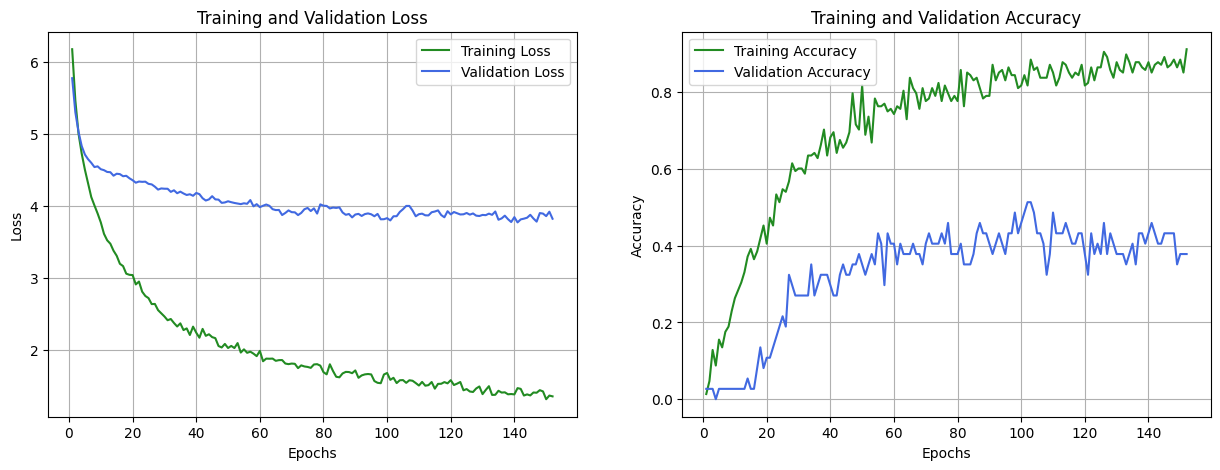

In [6]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

ax[0].plot(epochs, train_loss, color = 'forestgreen', label = 'Training Loss')
ax[0].plot(epochs, val_loss, color = 'royalblue', label = 'Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(epochs, train_acc, color = 'forestgreen', label = 'Training Accuracy')
ax[1].plot(epochs, val_acc, color = 'royalblue', label = 'Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()

In [ ]:
# Save the trained model as 'chatbot-model-about-diabete.h5' in the 'models' folder
# The .h5 file contains the model's structure and weights, enabling it to be reloaded at a later date.
model.save('../models/chatbot-model-about-diabete.h5')